## Monte Carlo simulation for NVT Ensemble

Reference: Computer Simulation of Liquid, 2017

Import packages

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from itertools import product

All particles are set at the center of a simple square lattice, at the initial state

In [6]:
def initCoords(pos, cells):
    num = len(pos)
    dim = len(pos[0])
    c   = np.zeros(dim)
    gap = 1. / cells

    assert dim == 3, "Wrong dimension, initCoords"

    n = 0
    for i, j, k in product(range(cells[0]), range(cells[1]), range(cells[2]) ):

        c      = np.array([i, j, k]) + 0.5
        c      = c * gap
        c      = c - 0.5
        pos[n] = c
        n      = n + 1

        if n >= num:
            return pos

    return pos


In [7]:
class PotentialType:
    """A compsite variable for interactions."""

    def __init__(self, pot, vir, ovr):
        self.pot = pot # Potential Energy
        self.vir = vir # Virial
        self.ovr = ovr # Check if overlap

    def __add__(self, other):
        pot = self.pot + other.pot
        vir = self.vir + other.vir
        ovr = self.ovr or other.ovr
        return PotentialType(pot, vir, ovr)

    def __sub__(self, other):
        pot = self.pot - other.pot
        vir = self.vir - other.vir
        ovr = self.ovr or other.ovr
        return PotentialType(pot, vir, ovr)


Calculate the interaction between particle $i$ and other particles.
The Lennard-Jones potential is used.

In [314]:
def potential_1( ri, box, r_cut, r ):

    dim      = len(r[0])
    r_cut_sq = r_cut ** 2

    assert dim == 3, "Dimension error for r in potential_1"

    sr2_ovr = 1.77 # Overlap threshold (pot > 100)

    rij      = ri - r
    rij      = rij - np.rint(rij)  # Periodical boundary conditions
    rij      = rij * box
    rij2     = np.sum(rij**2, axis = 1)
    in_range = rij2 < r_cut_sq
    sr2      = np.where(in_range, 1./rij2, 0)

    ovr = sr2 > sr2_ovr
    if np.any(ovr):
        partial = PotentialType( pot = 100.0, vir = 0.0, ovr = True )
        return partial

    sr6 = sr2 ** 3
    sr12 = sr6 ** 2

    pot = sr12 - sr6
    vir = pot + sr12
    partial = PotentialType ( pot=np.sum(pot), vir=np.sum(vir), ovr=False )

    partial.pot = partial.pot * 4.0          # 4 * epsilon
    partial.vir = partial.vir * 24.0 / 3.0   # 24 * epsilon and divide by 3.0

    return partial

def potential( box, r_cut, r ):
    """
    Calculate the total energy of the system
    """

    dim = len(r[0])
    num = len(r)
    assert dim == 3, "Dimension error for r in potential"

    total = PotentialType ( pot=0.0, vir=0.0, ovr=False )

    for i in range(num-1):
        partial = potential_1 ( r[i,:], box, r_cut, r[i+1:,:] )
        if partial.ovr:
            total.ovr = True
            break
        total = total + partial

    return total



Define some math function

In [9]:
def random_translate_vector ( dr_max, old ):
    zeta = np.random.rand(3)
    zeta = 2.0*zeta - 1.0
    return old + zeta * dr_max

def metropolis ( delta ):
    exponent_guard = 75.0

    if delta > exponent_guard: # Too high, reject without evaluating
        return False
    elif delta < 0.0:
        return True
    else:
        zeta = np.random.rand()
        return np.exp(-delta) > zeta

In [315]:
def MC_NVT(system):

    box = system["size"]
    vol = np.prod(system["size"])
    num = system["numberOfParticles"]
    rho = float(num) / vol

    rCut  = system["rCut"]
    drMax = system["drMax"]
    cells = system["cells"]

    nBlock = system["numberOfBlocks"]
    nStep  = system["numberOfSteps"]

    temperature = system["temperature"]

    r = np.zeros([num, 3])
    r = initCoords(r, cells)

    sr3 = 1.0 / rCut**3
    pressureDelta = np.pi * (8.0/3.0) * ( sr3**3 - sr3 ) * rho**2
    print("pressure delta: " + str(pressureDelta) )
    pressureLrc = np.pi * ( (32./9.) * sr3**3 - (16./3.) * sr3 ) * rho**2
    print("Pressure lrc: " + str(pressureLrc) )
    Ulrc = np.pi * ( (8./9.) * sr3**3 - (8./3.) * sr3 ) * rho
    print("Internal Energy LRC: " + str(Ulrc) )

    # Initial energy and check the particle position
    total = potential ( box, rCut, r )
    assert not total.ovr, "Overlap in the initial configuration"

    total.pot = total.pot + Ulrc

    moveRatio = 0.0
    moveRatios = []

    pressures   = []
    totalEnergy = []
    pots        = []

    for block in tqdm(range(nBlock)):

        for step in range(nStep):

            moves = 0

            for i in range(num):

                rj = np.delete(r, i, 0) # Array of all the other particles.
                partial_old = potential_1 ( r[i,:], box, rCut, rj )
                assert not partial_old.ovr, "Overlap in the current configuration"

                ri = random_translate_vector ( drMax/box, r[i,:] )
                ri = ri - np.rint ( ri )

                partial_new = potential_1 ( ri, box, rCut, rj )

                if not partial_new.ovr:
                    delta = partial_new.pot - partial_old.pot
                    delta = delta / temperature

                    if metropolis ( delta ):
                        total  = total + partial_new - partial_old
                        r[i,:] = ri
                        moves  = moves + 1


            # Test Particle Method
            rj = np.random.rand(3) - 0.5
            testParticle = potential_1 ( rj, box, rCut, r )
            #if testParticle.ovr:
            #    pot = 0
            #else:
            #    pot = np.exp( - testParticle.pot / temperature )
            pot = np.exp( - testParticle.pot / temperature )
            pots.append(pot)
            # End of Test Particle Method

            moveRatio = moves / num
            #pressure = rho * temperature + total.vir / vol + pressureDelta
            pressure = rho * temperature + total.vir / vol + pressureLrc

            # Test ratio of accepted to attempted moves
            if moveRatio > 0.55:
                drMax *= 1.05
            elif moveRatio < 0.45:
                drMax *= 0.95

            moveRatios.append(moveRatio)
            pressures.append(pressure)
            totalEnergy.append(total)

    total = potential ( box, rCut, r )
    assert not total.ovr, 'Overlap in final configuration'

    return pressures, moveRatios, totalEnergy, pots



In [197]:
system = {}
system["size"]              = np.array([10, 10, 10])
system["numberOfParticles"] = 400
system["temperature"]       = 2.
system["rCut"]              = 2.5
system["cells"]             = np.ceil( float( system["numberOfParticles"] / np.prod(system["size"]) )**(1./3.) * system["size"] )
system["cells"]             = system["cells"].astype(np.int64)
system["drMax"]             = 0.25
system["numberOfBlocks"]    = 10
system["numberOfSteps"]     = 1000

In [198]:
pressure, moveRatio, totalEnergy, pots = MC_NVT(system)

pressure delta: -0.08543504220380337
Pressure lrc: -0.17110433853442136
Internal Energy LRC: -0.21417324082654493


100%|██████████| 10/10 [03:47<00:00, 22.75s/it]


In [199]:
total = np.array( [i.pot for i in totalEnergy] )

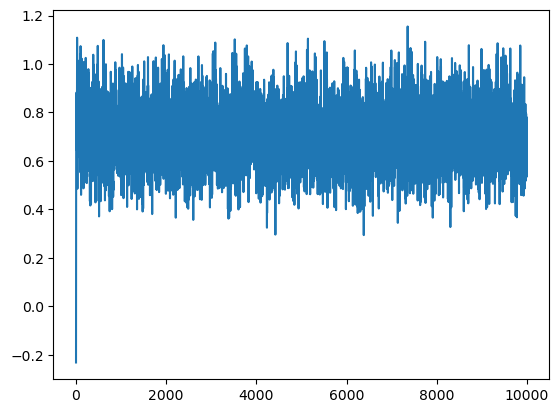

In [200]:
plt.plot(pressure)

In [201]:
np.mean( np.array(pressure[4000:]) )


0.7014324541586588

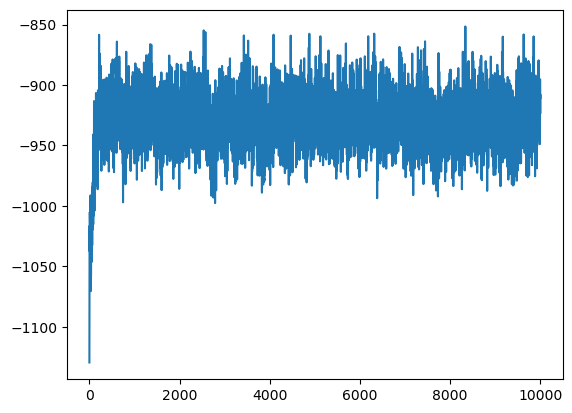

In [203]:
plt.plot(total)

In [205]:
np.mean( np.array(total[1000:] / 400) )

-2.322298907524714

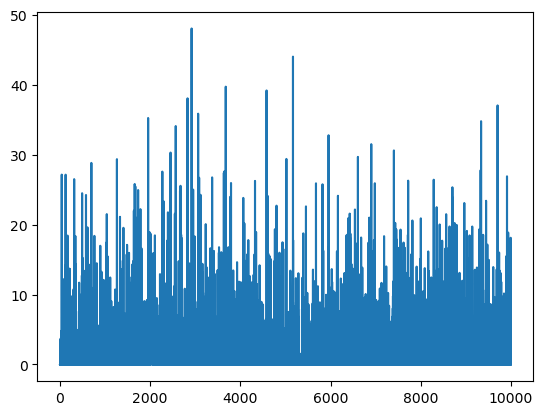

In [206]:
plt.plot( np.array(pots) )

In [209]:
chemPex = np.mean( np.array(pots[3000:]))
chemPex = - np.log( chemPex )
print( "Excess Chemical Potential: " + str(chemPex) )
chemP = np.log( 0.4 ) + chemPex
print( "Chemical Potential: " + str(chemP) )

Excess Chemical Potential: -0.23155188339697627
Chemical Potential: -1.1478426152711312


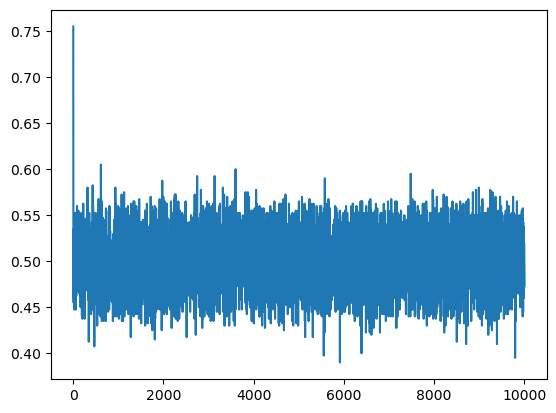

In [208]:
plt.plot(moveRatio)

In [316]:
testDensity = np.arange(100, 1000, 100)
p1   = []
m1   = []
t1   = []
pot1 = []
#pressure, moveRatio, totalEnergy, pots = MC_NVT(system)
for i in testDensity:
    system["numberOfParticles"] = i
    system["cells"] = np.ceil( float( system["numberOfParticles"] / np.prod(system["size"]) )**(1./3.) * system["size"] )
    system["cells"] = system["cells"].astype(np.int64)
    system["numberOfBlocks"] = 10
    p, m, t, pot = MC_NVT(system)
    p1.append(p)
    m1.append(m)
    t1.append(t)
    pot1.append(pot)

pres = [np.mean( np.array(i[2000:]) ) for i in p1]

pressure delta: -0.00533969013773771
Pressure lrc: -0.010694021158401335
Internal Energy LRC: -0.05354331020663623


 10%|█         | 1/10 [00:03<00:33,  3.75s/it]/var/folders/8r/4lys0f3j3s37f6sly02kgnv40000gn/T/ipykernel_79801/1044598037.py:15: RuntimeWarning: divide by zero encountered in divide
  sr2      = np.where(in_range, 1./rij2, 0)
100%|██████████| 10/10 [00:37<00:00,  3.74s/it]


pressure delta: -0.02135876055095084
Pressure lrc: -0.04277608463360534
Internal Energy LRC: -0.10708662041327247


100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


pressure delta: -0.04805721123963938
Pressure lrc: -0.09624619042561199
Internal Energy LRC: -0.16062993061990868


100%|██████████| 10/10 [02:33<00:00, 15.38s/it]


pressure delta: -0.08543504220380337
Pressure lrc: -0.17110433853442136
Internal Energy LRC: -0.21417324082654493


100%|██████████| 10/10 [03:40<00:00, 22.01s/it]


pressure delta: -0.13349225344344273
Pressure lrc: -0.2673505289600333
Internal Energy LRC: -0.26771655103318115


100%|██████████| 10/10 [04:57<00:00, 29.75s/it]


pressure delta: -0.19222884495855752
Pressure lrc: -0.38498476170244794
Internal Energy LRC: -0.32125986123981737


100%|██████████| 10/10 [06:42<00:00, 40.22s/it]


pressure delta: -0.26164481674914775
Pressure lrc: -0.5240070367616652
Internal Energy LRC: -0.3748031714464536


100%|██████████| 10/10 [08:09<00:00, 48.99s/it]


pressure delta: -0.34174016881521346
Pressure lrc: -0.6844173541376855
Internal Energy LRC: -0.42834648165308986


100%|██████████| 10/10 [09:43<00:00, 58.38s/it]


pressure delta: -0.4325149011567545
Pressure lrc: -0.866215713830508
Internal Energy LRC: -0.4818897918597261


100%|██████████| 10/10 [11:47<00:00, 70.72s/it]


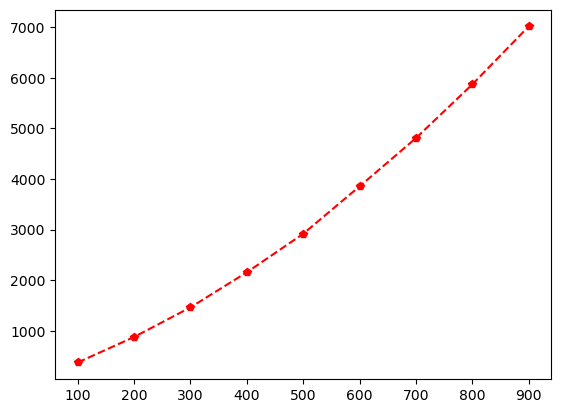

In [317]:
# ytime = np.array( [ 6.16, 14.40, 24.25, 35.58, 48.39, 1.04.16, 1.20.09, 1.37.51, 1.56.55 ] )
h1 = np.array( [ 0, 0, 0, 0, 0, 1, 1, 1, 1 ] )
m1 = np.array( [ 6, 14, 24, 35, 48, 4, 20, 37, 56 ] )
s1 = np.array( [ 16, 40, 25, 58, 39, 16, 9, 51, 55 ] )

yTime = h1 * 3600 + m1 * 60 + s1
xTime = np.arange(100, 1000, 100)

plt.plot(xTime, yTime, color="red", linestyle = "--", marker="p")

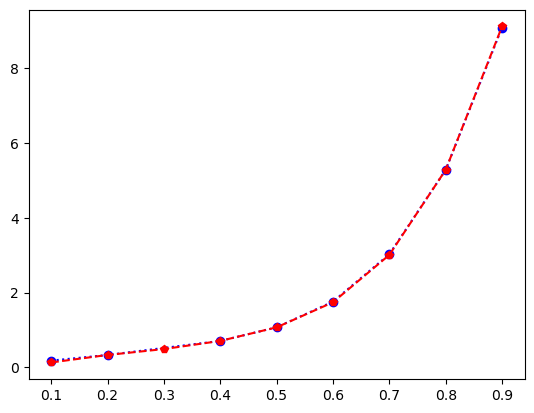

In [318]:
xx1 = np.array([0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
xx2 = np.arange(0.1, 1.0, 0.1)
yy1 = np.array([0.1777, 0.3290, 0.705, 1.069, 1.756, 3.024, 5.28, 9.09])

plt.plot(xx1, yy1, color="b", linestyle=":", marker="o")
plt.plot(xx2, pres, color="r", linestyle="--", marker="p")

# Data from MBWR paper 89 

In [295]:
testChemPex =  [
[0.0015643994119181048, -0.04676014027405717],
[0.0235830983764104, -0.1399367366551898],
[0.054167170524627384, -0.27976527644299587],
[0.08841720712062667, -0.41949834840664124],
[0.10676612292437027, -0.4971455120575854],
[0.13734255764665443, -0.6057242507366922],
[0.16791517365597208, -0.6986780888614508],
[0.19970977781455057, -0.7916001043781549],
[0.2388324921557271, -0.8687062836921857],
[0.27550359277244924, -0.9146263071136254],
[0.29872518632137013, -0.9296465781149568],
[0.32316876801955186, -0.9446350265082337],
[0.3500486885903221, -0.9283100285767016],
[0.3964727821233317, -0.8802260678076124],
[0.4416596126552148, -0.7696743274291791],
[0.4782848887163397, -0.6280955441984197],
[0.5148948899255987, -0.4240171587502619],
[0.5417251672278055, -0.20456845361218345],
[0.5746462917114836, 0.09316386733791227],
[0.5990173178633028, 0.37504852947728207],
[0.6209443677166007, 0.6568695464005456],
[0.6392054531221161, 0.9385950954996467],
[0.6586770705379931, 1.2672271688698515],
[0.6757161677942479, 1.5489208953609],
[0.6915218207623425, 1.8774575009069432],
[0.7109743446133874, 2.2842140770488975],
[0.7206929691129768, 2.5188421662285743],
[0.7291896054633056, 2.7534384328001975],
[0.7437694515691731, 3.097568116292538],
[0.7510479184832074, 3.3165076597017578],
[0.7619694375672255, 3.6292920742612376],
[0.7789550728419501, 4.129734408513183],
[0.7910833052233632, 4.505050247898115],
[0.7959330706907417, 4.661426543873829]
]

testChemPex = np.array( testChemPex )

# data from Frenkel's book

In [296]:
import MBWR_EOS

test = {"temperature": 2.0, "sigma": 1., "component":1, "epsilon":1., "wave":1.0}
CP = []

mbwr = MBWR_EOS.MBWR_EOS(test)
for i in xx2:
    mbwr.rho = i
    chemP = mbwr.exChemicalPotential()
    CP.append(chemP)

CP = np.array( CP )


In [297]:
yy = np.array([ -0.124232,  -0.186052, -0.172991, -0.0584114, 0.244226, 0.771789, 1.7077 ])
xx = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 ])

In [330]:
def uTail ( rho, rCut ):
    tail = (8./3.) * np.pi * rho * ( (1./3.) * (1./rCut)**9 - (1./rCut)**3 )
    return tail

tCPex = [ np.mean( np.array( i[2000:] ) ) for i in pot1 ]
tCPex = - np.log( tCPex )

xx2 = np.arange( 0.1, 1, 0.1 )
uts = []
for i in xx2:
    ut = uTail ( i, 2.5 )
    uts.append(ut)

tCPex = tCPex + 2*np.array( uts )

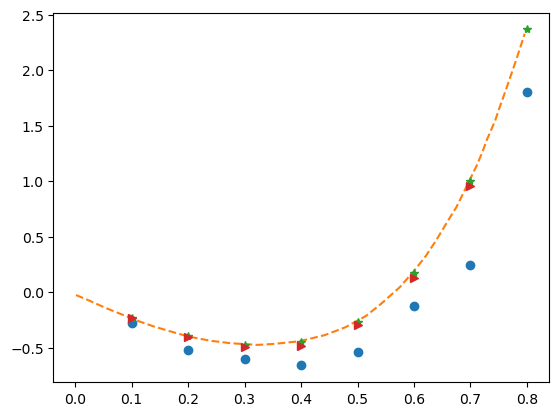

In [331]:
xx2 = np.arange(0.1, 1, 0.1)
plt.plot( xx2[:-1], tCPex[:-1], 'o' )
plt.plot( testChemPex[:,0], testChemPex[:,1]/2., "--")
plt.plot( xx2[:-1], CP[:-1,0,0], '*' )

plt.plot( xx, yy + 2*np.array(uts[:7]), ">" )

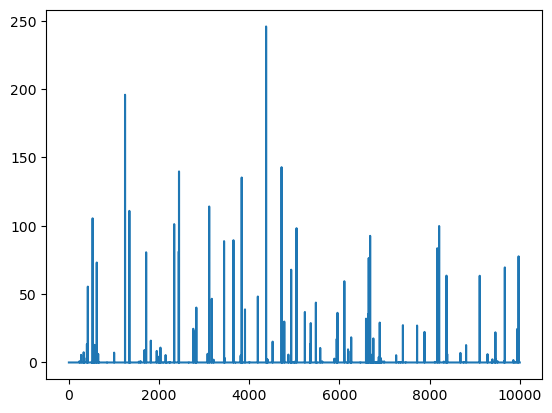

In [328]:
plt.plot( pot1[6])

In [329]:
np.log( 200 )

5.298317366548036

In [414]:
np.random.rand(3) - 0.5

array([-0.0493569 ,  0.12911859,  0.11989124])